# Differential gene expression analysis per cell-type between conditions

In [1]:
#Load libraries
import pandas as pd
import numpy as np
import scanpy as sc
import decoupler as dc
import biomart 
import os


In [2]:
#Load data
input_adata = "/data/projects/2023/atlas_protocol/input_data_zenodo/atlas-integrated-annotated.h5ad"
adata = sc.read_h5ad(input_adata)

In [3]:
#Processing
# Gene symbols required 
adata.var.head()

,is_highly_variable,mito,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
A1BG,True,False,86866,2.527138,90.681054,2355657.0
A1BG-AS1,True,False,12257,0.369194,98.685074,344142.0
A2M,True,False,122241,22.579874,86.886039,21047694.0
A2M-AS1,False,False,8827,0.172223,99.053043,160537.0
A2ML1,True,False,5096,0.038011,99.453303,35432.0


In [4]:
# All cells are annotated 
adata.obs["cell_type"].isnull().value_counts()

False    62119
Name: cell_type, dtype: int64

In [5]:
adata = adata[adata.obs["origin"] == "tumor_primary"]
adata = adata[adata.obs["condition"].isin(["LUAD", "LUSC"])]

In [6]:
# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata,use_rep="X_scANVI")

2023-04-06 09:52:07.665646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 09:52:07.975271: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-06 09:52:07.975343: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-06 09:52:09.315043: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

/home/kvalem/.conda/envs/2022-default-scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


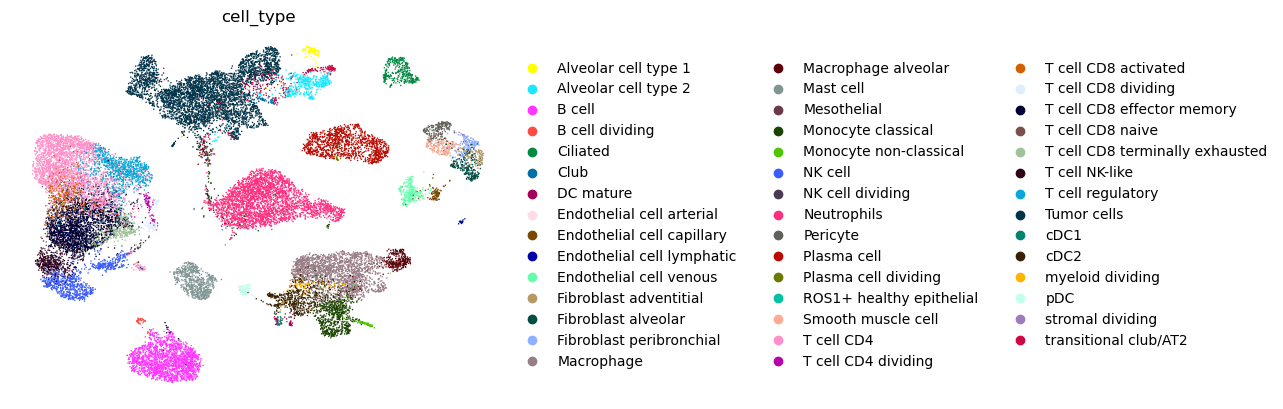

In [7]:
# Generate UMAP features
sc.tl.umap(adata, init_pos = "X_umap")
# Visualize
sc.pl.umap(adata, color=['cell_type'], frameon=False)

In [8]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(adata,
                          sample_col='patient',
                          groups_col='cell_type',
                          layer='raw_counts',
                          mode='sum',
                          min_cells=10,
                          min_counts=1000
                         )
pdata

AnnData object with n_obs × n_vars = 214 × 17837
    obs: 'uicc_stage', 'sex', 'ever_smoker', 'driver_genes', 'condition', 'age', 'patient', 'tissue', 'origin', 'dataset', 'cell_type', 'doublet_status', 'total_counts_mito', 'pct_counts_mito', 'cell_type_coarse', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'study', 'platform', 'platform_fine', 'cell_type_major', 'batch', '_predictions', '_leiden', '_cell_type_tumor_predicted', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

In [21]:
cell_type_name = "Tumor cells" # e.g Tumor cells
pdata_cell = pdata[(pdata.obs["cell_type"] == cell_type_name)]

In [22]:
# Create counts 
patient = pdata_cell.obs["patient"] #patient id
gene_symbol = pdata_cell.var.index #gene id as index
counts_df  = pd.DataFrame(data = pdata_cell.X, columns = gene_symbol, index =patient) #counts dataframe
counts_df.index.name = None
counts_df = counts_df.T
counts_df.index.name = "gene_symbol"

resDir = '/data/projects/2023/atlas_protocol/results/differential_expression/'
cell_type_name_no_space = cell_type_name.replace(" ","")
filename_co = f"{cell_type_name_no_space}_counts.tsv"
file_path = os.path.join(resDir, filename_co)
counts_df.to_csv(file_path,sep = "\t",index = True)


In [25]:
covariates = ['sex', 'ever_smoker', 'condition', 'age','tumor_stage', 'study', 'platform']
samplesheet_df = pdata_cell.obs.loc[:,covariates] # More columns can be added to be further used as covariates



samplesheet_df.index = samplesheet_df.index.str.replace("_"+cell_type_name,"")
samplesheet_df["sample"]= samplesheet_df.index

samplesheet_df.rename(columns = {"condition":"group"}, inplace = True) # Rename columns
samplesheet_df.index.name = None

filename_co = f"{cell_type_name_no_space}_samplesheet.csv"
file_path = os.path.join(resDir, filename_co)
samplesheet_df.to_csv(file_path,sep = ",",index = True)


In [3]:
! ../../bin/deseq2.R /data/projects/2023/atlas_protocol/results/differential_expression/Tumorcells_samplesheet.csv /data/projects/2023/atlas_protocol/results/differential_expression/Tumorcells_counts.tsv --c1 "LUAD" --c2 "LUSC"

Error in library("DESeq2") : there is no package called ‘DESeq2’
Execution halted
